In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np, yaml, cPickle as pickle
import data_io
import pandas as pd

golden = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
from sklearn.cross_validation import train_test_split


richness = pd.read_csv(
    data_io.large_base + '../diversity_labelled_data/resultAndSiteFiles/6SitesWith90Minutes.csv')

richness_files = set(xx.split('.')[0] for xx in richness.File)
# train_files, test_files = train_test_split(richness.File, test_size=0.25)

In [76]:
fname_to_richness = {}
for idx, row in richness.iterrows():
    
    fname_to_richness[row['File'].split('.')[0]] = sum(
        yy for xx, yy in row.iteritems() if xx != u'File')
    

In [34]:
sites = list(set(xx.split('_')[0] for xx in richness_files))
test_sites = sites[0:1]
train_sites = sites[1:]

In [40]:
test_files = [xx for xx in richness_files if xx.split('_')[0] in test_sites]
train_files = [xx for xx in richness_files if xx.split('_')[0] in train_sites]

In [54]:
import os

# a lookup for where to find each file
src1 = data_io.large_base + '../diversity_labelled_data/specs/mel/'
src2 = data_io.large_base + '/specs/mel/'

mapper = {}
for idx, src in enumerate([src1, src2]):
    for fname in os.listdir(src):
        mapper[fname.split('.')[0]] = (src, idx)


In [62]:
import cPickle as pickle 

mel_dir = data_io.large_base + '../diversity_labelled_data/specs/mel/'

def load_specs(fnames):
    specs = {}
    for fname in fnames:
        src, idx = mapper[fname]
        spec = pickle.load(open(src + fname + ['.wav', '.pkl'][idx]))
        specs[fname] = spec
    return specs
    

train_specs = load_specs(train_files)
test_specs = load_specs(test_files)

In [63]:
def compute_ACI(spectro,j_bin):
    """
    Compute the Acoustic Complexity Index from the spectrogram of an audio signal.
    Reference: Pieretti N, Farina A, Morri FD (2011) A new methodology to infer the singing activity of an avian community: the Acoustic Complexity Index (ACI). Ecological Indicators, 11, 868-873.
    Ported from the soundecology R package.
    spectro: the spectrogram of the audio signal
    j_bin: temporal size of the frame (in samples)
    """

    #times = range(0, spectro.shape[1], j_bin) # relevant time indices
    times = range(0, spectro.shape[1]-10, j_bin) # alternative time indices to follow the R code

    jspecs = [np.array(spectro[:,i:i+j_bin]) for i in times]  # sub-spectros of temporal size j

    aci = [sum((np.sum(abs(np.diff(jspec)), axis=1) / np.sum(jspec, axis=1))) for jspec in jspecs] 	# list of ACI values on each jspecs
    main_value = sum(aci)
    temporal_values = aci

    return main_value, temporal_values # return main (global) value, temporal values

def ACI_inspired_features(spec):
    return np.abs(np.diff(spec)).sum(axis=1)# / np.sum(spec, axis=1)


In [122]:
from copy import copy
def compute_features(_spec, annot):
    spec = copy(_spec)
    spec -= np.median(spec, 1, keepdims=True)
    just_biotic_normed = spec[:, annot > 0.5]
    just_biotic_unnormed = _spec[:, annot > 0.5]
    
    if just_biotic_normed.size == 0:
        return np.zeros(33)
    X = []
    X.append(just_biotic_normed.mean(1))
    X.append(just_biotic_unnormed.std(1))
    X.append(just_biotic_unnormed.mean(1))
    X.append(just_biotic_unnormed.std(1))
    X.append(just_biotic_unnormed.shape[1])
    X.append(ACI_inspired_features(just_biotic_unnormed))
    tmp = np.hstack(X)
    return tmp

def compute_all_feats(specs, fnames, annots):    
    X = []
    for fname in fnames:#, annots):
        X.append(compute_features(specs[fname], np.ones(spec.shape[1])))
    return np.vstack(X)
    
def load_annots(fnames):
    return np.hstack(fname_to_richness[fname] for fname in fnames)

#test_annots = [np.zeros(xx.shape[1]) for xx in test_specs]
test_X = compute_all_feats(test_specs, test_files, None)
train_X = compute_all_feats(train_specs, train_files, None)

test_y = load_annots(test_files)
train_y = load_annots(train_files)

print train_X.shape, train_y.shape, test_X.shape, test_y.shape

(449, 161) (449,) (89, 161) (89,)


/home/michael/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 1293 but corresponding boolean dimension is 1292
/home/michael/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 1293 but corresponding boolean dimension is 1292


In [123]:
print train_y

[ 0  2  4  0  0  0  0  0  0  2  0  0  7  0  0  0  0  0  5  4  0  1  0  0  0
  0  1  0  1  0  0  1  5  1  1  0  2  0  0  0  0  0  0  1  0  3  0  3  0  6
  0  1  3  2  0  1  0  0  1  0  0  8  0  2  1  4  0  0  8  0  0  4  1  0  9
  0  0  0  0  3  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  3  0
  1  2  2  0  0  0  0  0  0  0  0  0  7  0  0  1  0  2  0  0  3  0  1  0  0
  2  0  2  3  0  0  1  0  0  0  0  0  8  0  0  4  0  2  0  0  2  0  0  5  6
  3  0  0  0  0  1  0  1  0  0  0  5  1  0  0  0  0  0  6  0  6  0  6  0  0
  0  0  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  2  0
  1  5  0  0  0  0  0  4  0  0  2  0  0  5  8  0  0  0  0  0  0  0  0  0  0
  0  2  0  0  0  0  1  0  0  0  4  1  0  6  0  0  0  0  5  0  0  0  5  2  0
  1  0  6  0  0  3  1  0  1  0  0  0  3  0  0  0  1  1  0  0  0  0  8  2  0
  0  0  0  0  3  3  5  0  3 10  1  0  0  0  0  0  2  0  0  0  1  2  0  0  0
  0  1  2  1  0  0  0  0  5  0  0  0  0  0  3  0  0  0  4  0  0  1  0  0  0
  2  0  1  7

In [125]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(25, max_depth=25)
rf.fit(train_X, train_y)
pred_y = rf.predict(test_X)

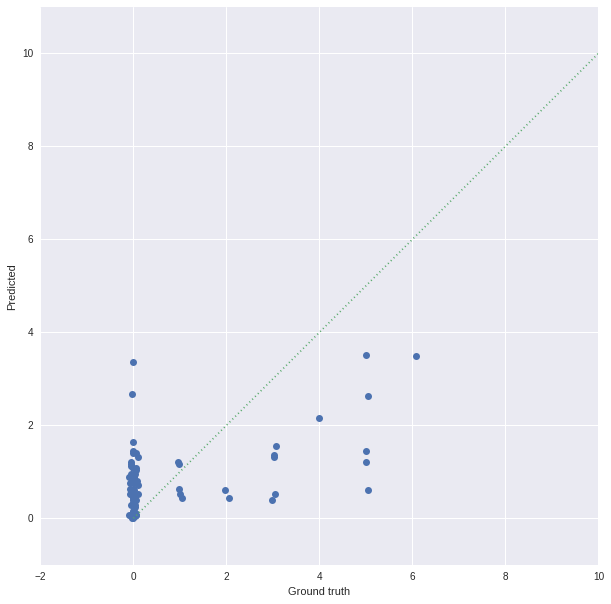

In [126]:
import seaborn as sns
plt.figure(figsize=(10, 10))
plt.plot(test_y + np.random.randn(test_y.shape[0]) * 0.05 , pred_y, 'o')
plt.xlabel('Ground truth')
plt.ylabel('Predicted')
plt.axis('equal')
plt.plot([0, 10], [0, 10], ':')